## League of Legends Competitive Analysis
    
    by Varun Nadgir

### The Problem

Using the competitive League of Legends match data provided by [Oracle's Elixir](http://oracleselixir.com/match-data/), I will be looking for trends in 'Champion' performance and regional playstyles, among other interesting findings I might come across. The idea is to put myself in the shoes of a professional gaming organization's analyst and try to find ways to give "our" team the edge against an opposing team. This would be particularly useful in international tournaments, when teams that never meet during the regular season challenge each other for the first time.

### The Data

The dataset consists of about 15,000 rows and almost 100 columns. Each game contains 12 rows - 5 for the players on one team, 5 for the other, and 2 for overall team averages. The first few columns are shared values, such as 'gameid', 'league', 'split', 'date' and other meta information regarding the game that was played, while the rest of the columns are in-game values, such as the 'Champion' picked and other performance factors. These data are taken from the 2018 Spring Split from each of the global regions - although we are in the middle of the 2018 Summer Split, I wanted to use a complete dataset.

### Goals

One of the first questions I was interested in exploring was "How do these Champions fare against each other?" This meant the most important variables for this question were the 'champion' and 'result' columns, so I began by shrinking the original dataset down to just containing the information about the region the game was played in, which of the five positions the Champion was played in, and whether or not they won that specific matchup. During this time, I realized that, unfortunately, not all of the 'gameid' values were unique, since some were duplicated across leagues. For now, I chose to separate the champion matchups by region, but one of the next steps will be to combine them. This would help teams when preparing for new competition - after scouting out the Champions they like to play, one could think of potential counters.

My second question *would* require some in-game values - "Does the team with an early lead win, more often than not?" The concept of "snowballing" a lead is a common one in League of Legends, yet some teams still find ways to come back through defensive play or by exploiting a single mistake of the enemy team. This question can also be explored through multiple avenues, such as first blood rate, gold lead, and/or turret/objective lead. I will be using a two-sample test to determine whether the means of wins and the means of losses are significantly different or not.

### Importing Data

In [9]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import matplotlib.mlab as mlab
import scipy.stats
import math

from scipy.stats import norm

# remove assignment warning for later step
pd.options.mode.chained_assignment = None  # default='warn'

# remove assignment warning for later step
pd.options.mode.chained_assignment = None  # default='warn'

# read in csv
loldf = pd.read_csv('loldata.csv')

C:\Users\FKBOX\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Champion Head-to-Head Performance

#### LCK 

To begin, I subsetted the data to only include the Korean league data. This keeps the data small and allows me to test the quality of the code before expanding.




In [2]:
# filter out specific columns needed
df = loldf[['gameid', 'league', 'position', 'team', 'champion', 'result']]
# list of unique gameid in the entire dataset
gamelist = df['gameid'].unique()

# subset data to just the LCK league (Korean)
lck = df[df['league']=='LCK']
# list of unique gameid from just the LCK
lck_gamelist = lck['gameid'].unique()

# subset the dataset to be separated by player position
top = df[df['position']=='Top']
jungle = df[df['position']=='Jungle']
middle = df[df['position']=='Middle']
ADC = df[df['position']=='ADC']
support = df[df['position']=='Support']

# subset the dataset to only include LCK Top champions
lck_top = lck[lck['position']=='Top']

In [3]:
# create groupby object based on 'gameid', each item contains winner and loser of the game
lck_group = lck_top.groupby('gameid')[['champion', 'result']]

# create a square matrix of 0's with rows/columns equal to number of unique champions picked
matrix = pd.DataFrame(0, index=lck_top['champion'].unique(), columns=lck_top['champion'].unique())

# loop through each unique gameid and add a 1 to each cell location where the ROW defeats the COLUMN
for i in range(len(lck_gamelist)):
    group_champs = lck_group.get_group(lck_gamelist[i]).sort_values('result', ascending=False)['champion']
    win_champ = group_champs.iloc[0]
    lose_champ = group_champs.iloc[1]
    matrix[lose_champ].loc[win_champ] += 1

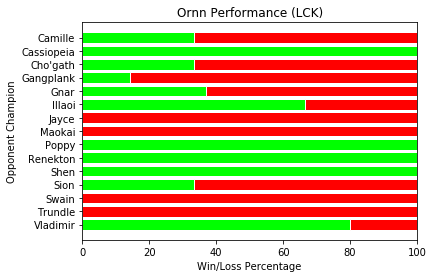

In [4]:
# make list of all unique champions picked
lcktop_champs = lck_top['champion'].unique()

# create empty lists for later
opponents = []
wins = []
losses = []

# store name of champion (select from 0 - 25)
champ = lcktop_champs[0]
# for each opponent in list of unique champs, add num wins and num losses to respective lists, record name of opponent
# skip those opponents with 0 wins and 0 losses (meaning they never met in-game)
for opp_champ in sorted(lcktop_champs, reverse=True):
    winSide = matrix.at[champ, opp_champ]
    lossSide = matrix.at[opp_champ, champ]
    if ((winSide+lossSide) > 0):
        wins.append(matrix.at[champ, opp_champ])
        losses.append(matrix.at[opp_champ, champ])
        opponents.append(opp_champ)

# create dataframe of wins/losses to be plotted
data = {'greenBars': wins, 'redBars': losses}
winrate_df = pd.DataFrame(data)

# calculate percentages of wins and losses vs each champion
totals = [x+y for x,y in zip(winrate_df['greenBars'], winrate_df['redBars'])]
greenBars = [x/y*100 for x,y in zip(winrate_df['greenBars'], totals)]
redBars = [x/y*100 for x,y in zip(winrate_df['redBars'], totals)]

# create horizontal bar plot to show performance vs everyone else
plt.barh(opponents, greenBars, edgecolor='white', color='#00ff00')
plt.barh(opponents, redBars, edgecolor='white', color='#ff0000', left=greenBars)

# label axes and show plot
plt.title(champ +" Performance (LCK)")
plt.xlabel('Win/Loss Percentage')
plt.ylabel('Opponent Champion')

plt.show()

#### All Major Regions

After completing the code for just LCK, it became possible to expand to all 5 major regions (North America, Europe, Southeast Asia, China, and Korea).

In [5]:
# apply same logic for all regions
major_regions = df[df['league'].isin(['NALCS', 'EULCS', 'LCK', 'LPL', 'LMS'])]
major_regions_top = major_regions[major_regions['position']=='Top']
major_regions_gamelist = major_regions['gameid'].unique()

In [6]:
# create groupby object based on 'gameid', each item contains winner and loser of the game
major_group = major_regions_top.groupby('gameid')[['champion', 'result']]

# create a square matrix of 0's with rows/columns equal to number of unique champions picked
major_matrix = pd.DataFrame(0, index=major_regions_top['champion'].unique(), columns=major_regions_top['champion'].unique())

# loop through each unique gameid and add a 1 to each cell location where the ROW defeats the COLUMN
for i in range(len(major_regions_gamelist)):
    major_group_champs = major_group.get_group(major_regions_gamelist[i]).sort_values('result', ascending=False)['champion']
    win_champ = major_group_champs.iloc[0]
    lose_champ = major_group_champs.iloc[1]
    major_matrix[lose_champ].loc[win_champ] += 1

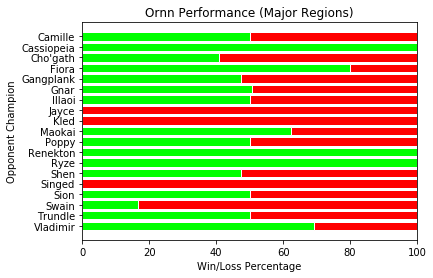

In [7]:
# make list of all unique champions picked
major_region_champs = major_regions_top['champion'].unique()

# create empty lists for later
opponents = []
wins = []
losses = []

# store name of champion (select from 0 - 32)
champ = major_region_champs[0]
# for each opponent in list of unique champs, add num wins and num losses to respective lists, record name of opponent
# skip those opponents with 0 wins and 0 losses (meaning they never met in-game)
for opp_champ in sorted(major_region_champs, reverse=True):
    winSide = major_matrix.at[champ, opp_champ]
    lossSide = major_matrix.at[opp_champ, champ]
    if ((winSide+lossSide) > 0):
        wins.append(major_matrix.at[champ, opp_champ])
        losses.append(major_matrix.at[opp_champ, champ])
        opponents.append(opp_champ)

# create dataframe of wins/losses to be plotted
data = {'greenBars': wins, 'redBars': losses}
winrate_df = pd.DataFrame(data)

# calculate percentages of wins and losses vs each champion
totals = [x+y for x,y in zip(winrate_df['greenBars'], winrate_df['redBars'])]
greenBars = [x/y*100 for x,y in zip(winrate_df['greenBars'], totals)]
redBars = [x/y*100 for x,y in zip(winrate_df['redBars'], totals)]

# create horizontal bar plot to show performance vs everyone else
plt.barh(opponents, greenBars, edgecolor='white', color='#00ff00')
plt.barh(opponents, redBars, edgecolor='white', color='#ff0000', left=greenBars)

# label axes and show plot
plt.title(champ +" Performance (Major Regions)")
plt.xlabel('Win/Loss Percentage')
plt.ylabel('Opponent Champion')

plt.show()

### Determining Effectiveness of Early-Game Leads

A prevalent concept in League of Legends, and many other games, is "snowballing" - where smaller leads develop into bigger ones that eventually become too hard to overcome. There are still cases of teams being neck and neck for a majority of a game, until a single decision swings it into one team's favour; as well as cases of a team having the lead for a large portion of a game, only to throw the game in the final moments. Using inferential statistics, I'd like to compare stats of winning teams to stats of losing teams to check for significant differences.


#### Some EDA

In [10]:
# get rows with just Team data
teams = loldf[loldf['player']=='Team']

# subset to certain columns of in-game stats
teams = teams[['gameid', 'league', 'team', 'result', 
               'teamdragkills', 'firedrakes', 'waterdrakes', 'earthdrakes', 'airdrakes', 'elders',
               'ft', 'firstmidouter', 'firsttothreetowers', 'fbaron', 'wards', 'wpm', 'visionwards', 
               'totalgold', 'goldspent', 'goldat10', 'goldat15', 'xpat10']]

# split dataset into a wins table and losses table
win_teams = teams[teams['result']==1]
lose_teams = teams[teams['result']==0]

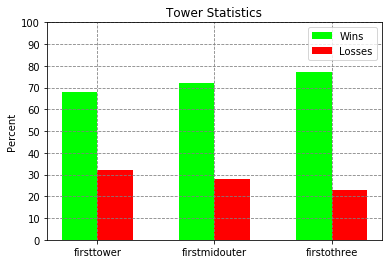

In [11]:
# take a look at tower stats
tower_stats = ['ft', 'firstmidouter', 'firsttothreetowers']

# get means for the three columns
tower_data_w = round(np.mean(win_teams[tower_stats])*100, 2)
tower_data_l = round(np.mean(lose_teams[tower_stats])*100, 2)

# create plot
_, ax = plt.subplots()
plt.bar(tower_stats, tower_data_w, color='#00ff00', width=-0.3, align='edge')
plt.bar(tower_stats, tower_data_l, color='#ff0000', width=0.3, align='edge')

# label axes and plot elements
plt.title('Tower Statistics')
plt.ylim((0,100))
plt.ylabel('Percent')
plt.legend(('Wins', 'Losses'))
plt.xticks(np.arange(3), ('firsttower', 'firstmidouter', 'firstothree'))
plt.yticks(np.arange(0, 101, step=10))
ax.grid(linestyle='dashed', color='grey')

plt.show()

What we can tell from this is that the winning team almost always has the lead when it comes to taking turrets - winning teams get the first tower almost 70% of the time. In 72% of games, they will take the mid-outer turret first, and in almost 80% of games, the team to destroy three towers first is the team to win. This should support the concept of snowballing, especially because of the increasing chances across this plot. The team who breaks the first tower may not always win, but if the first tower is the middle tower and/or if the first tower leads to breaking two additional towers, the likelihood of winning increases.

#### Dragons Taken by Winning vs Losing Teams

In [12]:
# get mean/std for dragons taken in wins
drag_win_mean = np.mean(win_teams['teamdragkills']) # ~2.464
drag_win_std = np.std(win_teams['teamdragkills']) # ~1.154
drag_win_count = len(win_teams) # 1251

# get mean/std for dragons taken in losses
drag_lose_mean = np.mean(lose_teams['teamdragkills']) # ~1.075
drag_lose_std = np.std(lose_teams['teamdragkills']) # ~1.170
drag_lose_count = len(lose_teams) # 1251

# calculate t-score
numerator = drag_win_mean - drag_lose_mean
denominator = np.sqrt(((drag_win_std**2)/drag_win_count) + ((drag_lose_std**2)/drag_lose_count))
t_score = numerator/denominator

# calculate p-value
pval = scipy.stats.t.sf(np.abs(t_score), 1250)*2

print("t_score: " + str(t_score) + "\np-value: " + str(pval))

t_score: 29.88601020655289
p-value: 1.5881366105366595e-148


With a t-score of 29.886, it is pretty safe to say that there is very likely a significant differences in these means. Using some of my own existing knowledge of the game, we typically only see 3-5 dragons taken in a game, so a mean of 2.464 for winning teams and 1.075 for losing teams makes it pretty clear that one team is winning. 

Additionally, the p-value is way below the significance level of 0.05, which also supports our rejection of the null hypothesis. Using this result and some knowledge of how a standard League of Legends game goes, it seems safe to say that teams that win get more dragons. However, this raises a similar question to towers - it is hard to say whether a team won because of taking dragons, or if they were able to take dragons because they were already in the lead. Unfortunately, this may be the case with many statistics we use because so much of the game is not in raw number data, but in decision-making and other intangibles.